In [1]:
# Mofication History
# v0.1 Initial setup
# v0.2 transfer learning
# v0.3 optimized all parameters
# v0.4 comparison
# v0.5 200 epoches
# v0.6 using TA's model

In [2]:
# Import library and framework
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import join, basename, isdir, isfile
import shutil

from PIL import Image
import time


In [3]:
# Parameter Claim
BATCH_SIZE = 64         # Batch Size
LR         = 0.1        # Initial Learning Rate
FREQ_SSR   = 4          # Times for showing accuracy for each epoch
#MODEL_NAME = 'RESNET18' # RESNET18 VGG
EPOCH      = 200        # Training Epoches
SAVE_ALL   = True       # SAVE ALL model or just architecture
IMAGE_SIZE = 224        # Image dimension
DO_TRAIN   = True       # Do train or only inference
MOMENTUM   = 0.9        # Momentum
W_DECAY    = 1e-4       # Weight Decay
GOAL_ACCU  = 95         # Early stop at goal accuracy
RESUME     = True       # Resume best training or start form epoch 0
UPDATE_ALL = True      # Update all parameter
LOAD_TA_MODEL = True

In [4]:
# Check CUDA information
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)
print("Our selected device: ", torch.cuda.current_device())
print("There are", torch.cuda.device_count(), "GPUs are available")


Current device:  cuda
Our selected device:  0
There are 1 GPUs are available


In [5]:
# define image loader, transformation and other tools
%run ./util.ipynb

# define training and validation procedure
%run ./train_proc.ipynb

In [6]:

if 0:#LOAD_TA_MODEL:
    filename='./ckpt/pretrained.ckpt'
    if isfile(filename):
        print("=> loading TA' checkpoint")
        checkpoint = torch.load(filename)
        
    else:
        print("Load fail")
        break
        
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(classes))
    #model = model.to(device)
    
    
    return checkpoint, epoch, best_accu, train_accu, val_accu, train_loss, val_loss
    
    
    
    classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')

    # 下載已訓練好的網路架構
    model = models.resnet101(pretrained=True)
    if not UPDATE_ALL:
        for param in model.parameters():
            param.requires_grad = False # 不更新梯度

    # 建立新的分類層，要更新梯度
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(classes))

    if not UPDATE_ALL:
        # 僅對FC層進行更新
        optimizer = optim.SGD(model.fc.parameters(), LR, momentum=MOMENTUM)
    else:
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

    # 學習率每7個epoch下降0.1
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    save_checkpoint({
            'epoch': 0,
            'state_dict': model.state_dict(),
            'best_accu'  : [0, 0],
            'optimizer' : optimizer.state_dict(),
            'accuracy'  : [[[], []], [[], []]],
            'loss'      : [[[], []], [[], []]], 
        }, True)

In [7]:
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')
model = models.resnet18(num_classes=len(classes))

In [16]:
# Main function
if __name__ == '__main__':
#def main():

    # Model Declaration
    classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')
        
    #model = models.resnet18()
    #num_ftrs = model.fc.in_features
    #model.fc = nn.Linear(num_ftrs, len(classes))
    #model = model.to(device)
    model = models.resnet18(num_classes=len(classes)).to(device)
    #show_distribution(model)
    
    #model_aug = models.resnet18()
    #num_ftrs_aug = model_aug.fc.in_features
    #model_aug.fc = nn.Linear(num_ftrs_aug, len(classes))
    #model_aug = model_aug.to(device)
    model_aug = models.resnet18(num_classes=len(classes)).to(device)

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    criterion_aug = nn.CrossEntropyLoss()
    optimizer_aug = optim.SGD(model_aug.parameters(), lr=LR, momentum=MOMENTUM)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    scheduler_aug = lr_scheduler.StepLR(optimizer_aug, step_size=7, gamma=0.1)
    
    
    # Data loading
    datadir = '../data'
    if not isdir(datadir):
        datadir = '/tmp/dataset-nctu'
    
    trainset = get_training_set(datadir)
    trainset_aug = get_training_set(datadir, aug="basic")
    validateset = get_validation_set(datadir)
    #evaluateset = get_evaluation_set(datadir)
    
    TRAIN_SIZE = len(trainset)
    VALIDATE_SIZE = len(validateset)
    #EVALUATE_SIZE = len(evaluateset)
    SUBEPOCH = int(np.ceil(TRAIN_SIZE / BATCH_SIZE / FREQ_SSR / 5) * 5)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validateloader = torch.utils.data.DataLoader(validateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    #evaluateloader = torch.utils.data.DataLoader(evaluateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
      

    epoch_init = 0
    best_accu = [0, 0]
    train_accu, train_loss = [[], []], [[], []]
    val_accu, val_loss = [[], []], [[], []]
    
    
    if LOAD_TA_MODEL and not isfile('./ckpt/model_best.pth.tar'):
        #filename='./ckpt/pretrained.ckpt'
        #filename='./ckpt/new_pretrained.ckpt'
        filename='./ckpt/model_best_LAB1-2.pth.tar'
        if isfile(filename):
            print("=> loading TA's checkpoint")
            checkpoint = torch.load(filename)
            model.load_state_dict(checkpoint['state_dict'])
            model_aug.load_state_dict(checkpoint['state_dict'])

        else:
            print("Load TA's checkpoint fail")

            
    elif RESUME:
        print("=> loading the best checkpoint")
        checkpoint, epoch_init, best_accu, train_accu, val_accu, train_loss, val_loss = load_best_checkpoint()
        if checkpoint != None:
            model.load_state_dict(checkpoint['state_dict'][0])
            optimizer.load_state_dict(checkpoint['optimizer'][0])
            model_aug.load_state_dict(checkpoint['state_dict'][1])
            optimizer_aug.load_state_dict(checkpoint['optimizer'][1])
    else:
        print("Train in the all new stage")
    
    print("Training")
    #show_distribution(model)
    
    validate(validateloader, model, criterion)
    

basic aug
=> loading TA's checkpoint
Training
           validation accuracy: 80.8%
           validation loss    : 0.607


[1,    40] loss: 0.329
[1,    80] loss: 0.558
[1,   120] loss: 0.487
  1 epoch, training accuracy: 84.2%
           training loss    : 0.446
[1,    40] loss: 1.284
[1,    80] loss: 1.156
[1,   120] loss: 1.123
  1 epoch, training accuracy: 61.0%
           training loss    : 1.165
           validation accuracy: 70.9%
           validation loss    : 0.960
           validation accuracy: 67.7%
           validation loss    : 1.004
[2,    40] loss: 0.239
[2,    80] loss: 0.270
[2,   120] loss: 0.334
  2 epoch, training accuracy: 89.5%
           training loss    : 0.285
[2,    40] loss: 1.110
[2,    80] loss: 1.055
[2,   120] loss: 1.006
  2 epoch, training accuracy: 64.8%
           training loss    : 1.048
           validation accuracy: 72.5%
           validation loss    : 0.956
           validation accuracy: 70.2%
           validation loss    : 0.903
[3,    40] loss: 0.191
[3,    80] loss: 0.184
[3,   120] loss: 0.225
  3 epoch, training accuracy: 92.3%
           training loss   

           validation accuracy: 79.3%
           validation loss    : 0.630
[20,    40] loss: 0.002
[20,    80] loss: 0.002
[20,   120] loss: 0.002
 20 epoch, training accuracy: 99.4%
           training loss    : 0.003
[20,    40] loss: 0.671
[20,    80] loss: 0.615
[20,   120] loss: 0.636
 20 epoch, training accuracy: 78.6%
           training loss    : 0.633
           validation accuracy: 79.1%
           validation loss    : 0.930
           validation accuracy: 79.0%
           validation loss    : 0.625
[21,    40] loss: 0.002
[21,    80] loss: 0.002
[21,   120] loss: 0.002
 21 epoch, training accuracy: 99.5%
           training loss    : 0.003
[21,    40] loss: 0.644
[21,    80] loss: 0.628
[21,   120] loss: 0.652
 21 epoch, training accuracy: 78.6%
           training loss    : 0.636
           validation accuracy: 78.8%
           validation loss    : 0.943
           validation accuracy: 79.1%
           validation loss    : 0.626
[22,    40] loss: 0.002
[22,    80] loss: 0.

[39,    40] loss: 0.002
[39,    80] loss: 0.002
[39,   120] loss: 0.002
 39 epoch, training accuracy: 99.5%
           training loss    : 0.002
[39,    40] loss: 0.639
[39,    80] loss: 0.636
[39,   120] loss: 0.635
 39 epoch, training accuracy: 78.1%
           training loss    : 0.636
           validation accuracy: 78.8%
           validation loss    : 0.932
           validation accuracy: 79.1%
           validation loss    : 0.627
[40,    40] loss: 0.002
[40,    80] loss: 0.002
[40,   120] loss: 0.002
 40 epoch, training accuracy: 99.5%
           training loss    : 0.002
[40,    40] loss: 0.626
[40,    80] loss: 0.637
[40,   120] loss: 0.637
 40 epoch, training accuracy: 78.4%
           training loss    : 0.637
           validation accuracy: 78.7%
           validation loss    : 0.946
           validation accuracy: 79.2%
           validation loss    : 0.626
[41,    40] loss: 0.002
[41,    80] loss: 0.002
[41,   120] loss: 0.002
 41 epoch, training accuracy: 99.5%
           t

           validation accuracy: 78.8%
           validation loss    : 0.944
           validation accuracy: 79.2%
           validation loss    : 0.625
[58,    40] loss: 0.002
[58,    80] loss: 0.002
[58,   120] loss: 0.002
 58 epoch, training accuracy: 99.5%
           training loss    : 0.002
[58,    40] loss: 0.674
[58,    80] loss: 0.620
[58,   120] loss: 0.608
 58 epoch, training accuracy: 79.0%
           training loss    : 0.629
           validation accuracy: 78.9%
           validation loss    : 0.932
           validation accuracy: 79.3%
           validation loss    : 0.625
[59,    40] loss: 0.002
[59,    80] loss: 0.002
[59,   120] loss: 0.002
 59 epoch, training accuracy: 99.5%
           training loss    : 0.002
[59,    40] loss: 0.644
[59,    80] loss: 0.613
[59,   120] loss: 0.665
 59 epoch, training accuracy: 78.6%
           training loss    : 0.634
           validation accuracy: 79.1%
           validation loss    : 0.934
           validation accuracy: 79.3%
      

[76,    40] loss: 0.626
[76,    80] loss: 0.591
[76,   120] loss: 0.678
 76 epoch, training accuracy: 78.0%
           training loss    : 0.642
           validation accuracy: 79.0%
           validation loss    : 0.940
           validation accuracy: 79.4%
           validation loss    : 0.631
[77,    40] loss: 0.002
[77,    80] loss: 0.002
[77,   120] loss: 0.002
 77 epoch, training accuracy: 99.4%
           training loss    : 0.003
[77,    40] loss: 0.659
[77,    80] loss: 0.625
[77,   120] loss: 0.627
 77 epoch, training accuracy: 78.4%
           training loss    : 0.639
           validation accuracy: 79.1%
           validation loss    : 0.936
           validation accuracy: 79.3%
           validation loss    : 0.627
[78,    40] loss: 0.002
[78,    80] loss: 0.002
[78,   120] loss: 0.002
 78 epoch, training accuracy: 99.5%
           training loss    : 0.002
[78,    40] loss: 0.630
[78,    80] loss: 0.641
[78,   120] loss: 0.640
 78 epoch, training accuracy: 78.0%
           t

[95,    40] loss: 0.002
[95,    80] loss: 0.003
[95,   120] loss: 0.002
 95 epoch, training accuracy: 99.5%
           training loss    : 0.002
[95,    40] loss: 0.657
[95,    80] loss: 0.648
[95,   120] loss: 0.630
 95 epoch, training accuracy: 78.4%
           training loss    : 0.645
           validation accuracy: 78.9%
           validation loss    : 0.939
           validation accuracy: 79.2%
           validation loss    : 0.629
[96,    40] loss: 0.003
[96,    80] loss: 0.003
[96,   120] loss: 0.002
 96 epoch, training accuracy: 99.5%
           training loss    : 0.002
[96,    40] loss: 0.643
[96,    80] loss: 0.632
[96,   120] loss: 0.592
 96 epoch, training accuracy: 78.8%
           training loss    : 0.625
           validation accuracy: 79.2%
           validation loss    : 0.925
           validation accuracy: 79.2%
           validation loss    : 0.624
[97,    40] loss: 0.002
[97,    80] loss: 0.002
[97,   120] loss: 0.002
 97 epoch, training accuracy: 99.5%
           t

[113,   120] loss: 0.622
113 epoch, training accuracy: 78.6%
           training loss    : 0.627
           validation accuracy: 78.8%
           validation loss    : 0.961
           validation accuracy: 79.3%
           validation loss    : 0.621
[114,    40] loss: 0.002
[114,    80] loss: 0.002
[114,   120] loss: 0.002
114 epoch, training accuracy: 99.5%
           training loss    : 0.003
[114,    40] loss: 0.618
[114,    80] loss: 0.638
[114,   120] loss: 0.631
114 epoch, training accuracy: 78.7%
           training loss    : 0.635
           validation accuracy: 79.1%
           validation loss    : 0.944
           validation accuracy: 79.4%
           validation loss    : 0.628
[115,    40] loss: 0.002
[115,    80] loss: 0.002
[115,   120] loss: 0.002
115 epoch, training accuracy: 99.5%
           training loss    : 0.002
[115,    40] loss: 0.620
[115,    80] loss: 0.636
[115,   120] loss: 0.655
115 epoch, training accuracy: 78.5%
           training loss    : 0.642
           

[132,    40] loss: 0.651
[132,    80] loss: 0.630
[132,   120] loss: 0.656
132 epoch, training accuracy: 78.5%
           training loss    : 0.639
           validation accuracy: 78.9%
           validation loss    : 0.930
           validation accuracy: 79.5%
           validation loss    : 0.629
[133,    40] loss: 0.002
[133,    80] loss: 0.002
[133,   120] loss: 0.002
133 epoch, training accuracy: 99.4%
           training loss    : 0.003
[133,    40] loss: 0.656
[133,    80] loss: 0.617
[133,   120] loss: 0.669
133 epoch, training accuracy: 78.5%
           training loss    : 0.646
           validation accuracy: 78.8%
           validation loss    : 0.936
           validation accuracy: 79.4%
           validation loss    : 0.623
[134,    40] loss: 0.002
[134,    80] loss: 0.003
[134,   120] loss: 0.002
134 epoch, training accuracy: 99.5%
           training loss    : 0.003
[134,    40] loss: 0.600
[134,    80] loss: 0.663
[134,   120] loss: 0.638
134 epoch, training accuracy: 78.

           validation accuracy: 79.6%
           validation loss    : 0.628
[151,    40] loss: 0.002
[151,    80] loss: 0.002
[151,   120] loss: 0.002
151 epoch, training accuracy: 99.5%
           training loss    : 0.002
[151,    40] loss: 0.648
[151,    80] loss: 0.642
[151,   120] loss: 0.658
151 epoch, training accuracy: 78.2%
           training loss    : 0.647
           validation accuracy: 78.9%
           validation loss    : 0.938
           validation accuracy: 79.1%
           validation loss    : 0.629
[152,    40] loss: 0.002
[152,    80] loss: 0.002
[152,   120] loss: 0.002
152 epoch, training accuracy: 99.5%
           training loss    : 0.002
[152,    40] loss: 0.628
[152,    80] loss: 0.616
[152,   120] loss: 0.674
152 epoch, training accuracy: 78.3%
           training loss    : 0.636
           validation accuracy: 79.2%
           validation loss    : 0.929
           validation accuracy: 79.5%
           validation loss    : 0.622
[153,    40] loss: 0.003
[153,  

[169,    40] loss: 0.622
[169,    80] loss: 0.653
[169,   120] loss: 0.660
169 epoch, training accuracy: 78.1%
           training loss    : 0.639
           validation accuracy: 78.8%
           validation loss    : 0.949
           validation accuracy: 79.1%
           validation loss    : 0.631
[170,    40] loss: 0.002
[170,    80] loss: 0.002
[170,   120] loss: 0.003
170 epoch, training accuracy: 99.4%
           training loss    : 0.002
[170,    40] loss: 0.673
[170,    80] loss: 0.640
[170,   120] loss: 0.618
170 epoch, training accuracy: 78.4%
           training loss    : 0.643
           validation accuracy: 78.8%
           validation loss    : 0.941
           validation accuracy: 79.5%
           validation loss    : 0.626
[171,    40] loss: 0.002
[171,    80] loss: 0.002
[171,   120] loss: 0.003
171 epoch, training accuracy: 99.5%
           training loss    : 0.002
[171,    40] loss: 0.648
[171,    80] loss: 0.639
[171,   120] loss: 0.659
171 epoch, training accuracy: 77.

[188,   120] loss: 0.002
188 epoch, training accuracy: 99.5%
           training loss    : 0.002
[188,    40] loss: 0.622
[188,    80] loss: 0.636
[188,   120] loss: 0.681
188 epoch, training accuracy: 78.3%
           training loss    : 0.644
           validation accuracy: 79.3%
           validation loss    : 0.933
           validation accuracy: 79.3%
           validation loss    : 0.624
[189,    40] loss: 0.002
[189,    80] loss: 0.003
[189,   120] loss: 0.002
189 epoch, training accuracy: 99.5%
           training loss    : 0.002
[189,    40] loss: 0.609
[189,    80] loss: 0.639
[189,   120] loss: 0.648
189 epoch, training accuracy: 78.7%
           training loss    : 0.634
           validation accuracy: 78.9%
           validation loss    : 0.934
           validation accuracy: 79.5%
           validation loss    : 0.625
[190,    40] loss: 0.002
[190,    80] loss: 0.002
[190,   120] loss: 0.002
190 epoch, training accuracy: 99.5%
           training loss    : 0.002
[190,    40

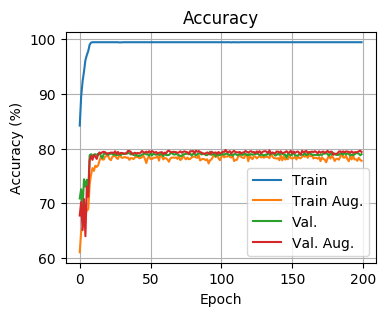

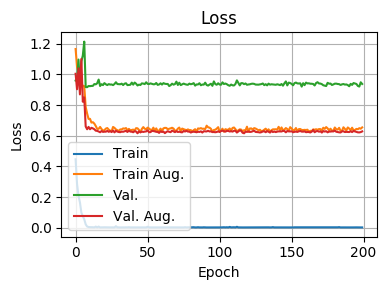

In [17]:
    # Do Training
    if DO_TRAIN:
        for epoch in range(epoch_init, EPOCH):  # loop over the dataset multiple times

            # Adjust learning rate
            #adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            accu, loss = train(trainloader, model, criterion, optimizer, scheduler, epoch, SUBEPOCH)
            train_accu[0].append(accu)
            train_loss[0].append(loss)

            accu_aug, loss_aug = train(trainloader_aug, model_aug, criterion_aug, optimizer_aug, scheduler_aug, epoch, SUBEPOCH)
            train_accu[1].append(accu_aug)
            train_loss[1].append(loss_aug)

            # evaluate on validation set
            accu, loss = validate(validateloader, model, criterion)
            val_accu[0].append(accu)
            val_loss[0].append(loss)
            accu_aug, loss_aug = validate(validateloader, model_aug, criterion_aug)
            val_accu[1].append(accu_aug)
            val_loss[1].append(loss_aug)

            # remember best prec@1 and save checkpoint
            is_best = accu > best_accu[0] or accu_aug > best_accu[1]
            best_accu = [max(accu, best_accu[0]), max(accu_aug, best_accu[1])]
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': [model.state_dict(), model_aug.state_dict()],
                'best_accu' : best_accu,
                'optimizer' : [optimizer.state_dict(), optimizer_aug.state_dict()],
                'accuracy'  : [train_accu, val_accu],
                'loss'      : [train_loss, val_loss], 
            }, is_best)

        draw_dual_accuracy(train_accu, train_loss, val_accu, val_loss)
        print('Finished Training')

In [ ]:
#if __name__ == '__main__':
#    #main()
%run ./util.ipynb
#draw_accuracy(train_accu, train_loss, val_accu, val_loss)
draw_dual_accuracy(train_accu, train_loss, val_accu, val_loss)

In [11]:
def show_dual_class_accuracy(eva_accuracy, eva_loss, accu_class, eva_accuracy_aug, eva_loss_aug, accu_class_aug, classes):
    y_pos = np.arange(len(classes))

    fig, ax1 = plt.subplots(1,1)
    plt.rcdefaults()
            
    plt.barh(y_pos, accu_class, align='center', alpha=0.4)
    plt.barh(y_pos, accu_class_aug, align='center', alpha=0.4)
    plt.yticks(y_pos, classes)
    plt.xlabel('Accuracy(%)')

    plt.title('Total accuracy of w/ & w/o data aumentation: {:.2f}%, {:.2f}%'.format(eva_accuracy, eva_accuracy_aug))

    for xx, yy in zip(accu_class, y_pos):
        plt.text(xx, yy, '{:.2f}'.format(xx), ha='center')
    for xx, yy in zip(accu_class_aug, y_pos):
        plt.text(xx, yy, '{:.2f}'.format(xx), ha='center')

Loading the best checkpoint...
=> loading best checkpoint


Doing evaluation-----
           evaluation accuracy: 13.3%
           evaluation loss    : 2.346
Total evaluation accuracy is 13.30% and loss is 2.34629
For each class in Food-11:
    Accuracy of Vegetable/Fruit : 4.76%
    Accuracy of Soup            : 0.00%
    Accuracy of Seafood         : 3.30%
    Accuracy of Rice            : 0.00%
    Accuracy of Noodles/Pasta   : 0.00%
    Accuracy of Meat            : 98.61%
    Accuracy of Fried food      : 0.00%
    Accuracy of Egg             : 0.00%
    Accuracy of Dessert         : 0.80%
    Accuracy of Dairy product   : 0.00%
    Accuracy of Bread           : 0.00%
           evaluation accuracy: 14.7%
           evaluation loss    : 2.331
Total evaluation accuracy is 14.71% and loss is 2.33077
For each class in Food-11:
    Accuracy of Vegetable/Fruit : 0.00%
    Accuracy of Soup            : 0.00%
    Accuracy of Seafood         : 0.33%
    Accuracy of Rice            : 0.00%

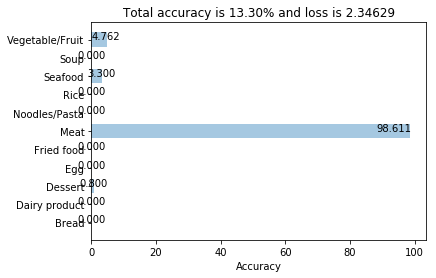

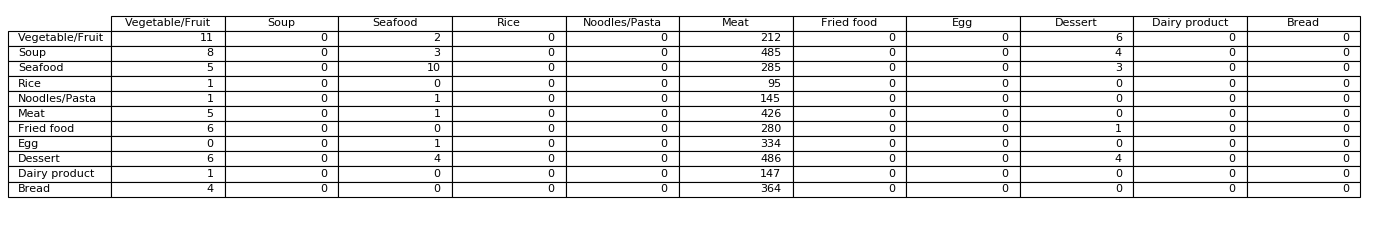

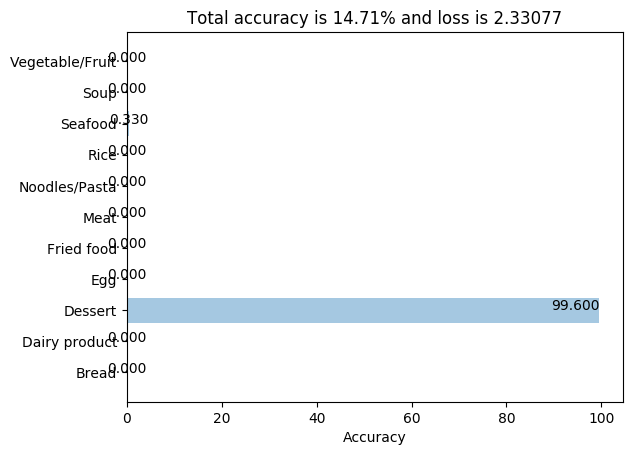

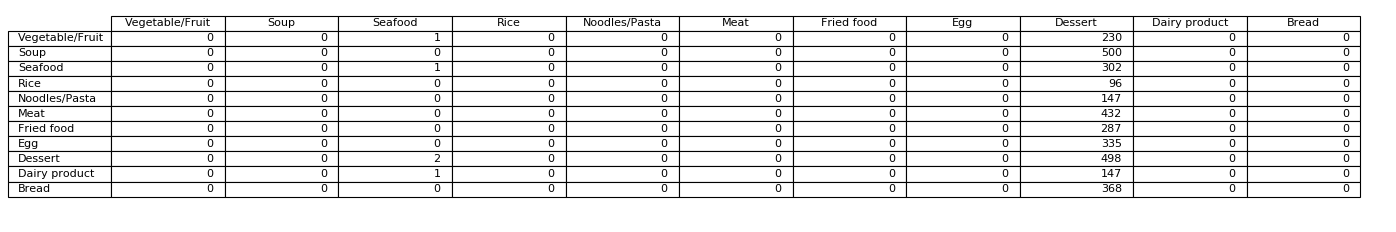

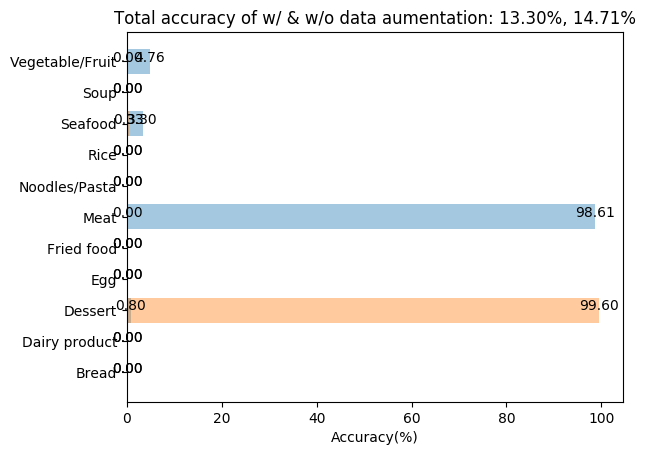

In [12]:
#%run ./util.ipynb
#%run ./train_proc.ipynb

if 1:
    print("Loading the best checkpoint...")
    checkpoint, epoch_init, best_accu, train_accu, val_accu, train_loss, val_loss = load_best_checkpoint()
    if checkpoint != None:
        model.load_state_dict(checkpoint['state_dict'][0])
        optimizer.load_state_dict(checkpoint['optimizer'][0])
        model_aug.load_state_dict(checkpoint['state_dict'][1])
        optimizer_aug.load_state_dict(checkpoint['optimizer'][1])         
            
print('\n\nDoing evaluation-----')
evaluateset = get_evaluation_set(datadir)
evaluateloader = torch.utils.data.DataLoader(evaluateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
eva_accuracy, eva_loss, accu_class = evaluate(evaluateloader, model, criterion, classes)
eva_accuracy_aug, eva_loss_aug, accu_class_aug = evaluate(evaluateloader, model_aug, criterion_aug, classes)

show_dual_class_accuracy(eva_accuracy, eva_loss, accu_class, eva_accuracy_aug, eva_loss_aug, accu_class_aug, classes)

In [ ]:
show_dual_class_accuracy(eva_accuracy, eva_loss, accu_class, eva_accuracy_aug, eva_loss_aug, accu_class_aug, classes)


In [ ]:
#!mkdir ckpt

In [ ]:
"""
net_SGD         = models.inception_v3(num_classes=len(classes))
    net_Momentum    = models.inception_v3(num_classes=len(classes))
    net_RMSprop     = models.inception_v3(num_classes=len(classes))
    net_Adam        = models.inception_v3(num_classes=len(classes))
    nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]
# different optimizers
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], []]   # 记录 training 时不同神经网络的 loss
"""

In [15]:
!pwd
!ls ckpt

/home/dllab/work/LAB2-1
model_best_aug_v0.3.pth.tar  model_best_aug_v0.5.pth.tar  new_pretrained.ckpt
model_best_aug_v0.4.pth.tar  model_best_LAB1-2.pth.tar	  pretrained.ckpt


In [14]:
!cp ../LAB1-2/ckpt/model_best.pth.tar ./ckpt/.

cp: cannot stat '../LAB1-2/ckpt/model_best.pth.tar': No such file or directory
